In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[0]  # importing functions from other folders
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from _data.data_utils import read_in
from _fitting.fitting_utils import hist_plot, CI_plot, CI_plot_alt, CI_plot_both
import pymc as pm
import arviz as az
from patsy import dmatrix
import nutpie

az.style.use("arviz-darkgrid")

laptop_or_server = 1
if laptop_or_server:
    # laptop folder
    folder = "../../_data/p-dengue/"
else:
    # server folder
    folder = "../../../data/lucaratzinger_data/p-dengue/"

In [2]:
data = read_in(folder, admin=2, max_lag=0)
data = data.dropna()
data = data.loc[data['year']<2020, :]

rng = np.random.default_rng(42)
keep_admin2 = rng.choice(
    data["admin2"].unique(),
    size=int(0.5 * data["admin2"].nunique()),
    replace=False
)
#data = data[data["admin2"].isin(keep_admin2)]

In [3]:
data

,admin1,admin2,year,month,cases,ONI,t2m_mean_unweighted (0),t2m_mean_pop_weighted (0),t2m_min_unweighted (0),t2m_min_pop_weighted (0),...,urbanisation_nonweighted,urbanisation_pop_weighted,surveillance_nonweighted,surveillance_pop_weighted,urban_surveillance_nonweighted,urban_surveillance_pop_weighted,density_unweighted,density_pop_weighted,urban_density_unweighted,urban_density_pop_weighted
0,ACEH,SIMEULUE,2016,1,1.0,2.48,300.32922,300.347840,297.62756,297.676417,...,0.010998,0.078463,0.306564,0.389898,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631
1,ACEH,SIMEULUE,2016,2,8.0,2.14,300.51236,300.532226,297.90063,297.925451,...,0.010998,0.078463,0.306564,0.389898,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631
2,ACEH,SIMEULUE,2016,3,9.0,1.58,300.52810,300.551347,298.03680,298.078477,...,0.010998,0.078463,0.306564,0.389898,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631
3,ACEH,SIMEULUE,2016,4,14.0,0.94,300.54373,300.565193,298.26874,298.297523,...,0.010998,0.078463,0.306564,0.389898,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631
4,ACEH,SIMEULUE,2016,5,4.0,0.39,300.65067,300.670510,298.33392,298.373199,...,0.010998,0.078463,0.306564,0.389898,0.774953,0.768781,42.316379,715.475930,296.269231,1066.646631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55447,PAPUA,KOTA JAYAPURA,2019,8,5.0,0.14,298.17090,298.246027,295.41640,295.472186,...,0.100398,0.925304,0.552229,0.859279,0.843776,0.879689,417.696629,31430.571662,3822.020202,33724.027438
55448,PAPUA,KOTA JAYAPURA,2019,9,1.0,0.19,298.61910,298.666391,295.49188,295.627868,...,0.100398,0.925304,0.552229,0.859279,0.843776,0.879689,417.696629,31430.571662,3822.020202,33724.027438
55449,PAPUA,KOTA JAYAPURA,2019,10,1.0,0.35,298.49250,298.539236,295.24090,295.316480,...,0.100398,0.925304,0.552229,0.859279,0.843776,0.879689,417.696629,31430.571662,3822.020202,33724.027438
55450,PAPUA,KOTA JAYAPURA,2019,11,1.0,0.51,298.82916,298.881520,295.82224,295.915472,...,0.100398,0.925304,0.552229,0.859279,0.843776,0.879689,417.696629,31430.571662,3822.020202,33724.027438


In [19]:
list(data.columns)

['admin1',
 'admin2',
 'year',
 'month',
 'cases',
 'ONI',
 't2m_mean_unweighted (0)',
 't2m_mean_pop_weighted (0)',
 't2m_min_unweighted (0)',
 't2m_min_pop_weighted (0)',
 't2m_max_unweighted (0)',
 't2m_max_pop_weighted (0)',
 'rh_mean_unweighted (0)',
 'rh_mean_pop_weighted (0)',
 'tp_24hmean_unweighted (0)',
 'tp_24hmean_pop_weighted (0)',
 'tp_24hmax_unweighted (0)',
 'tp_24hmax_pop_weighted (0)',
 'population',
 'urbanisation_nonweighted',
 'urbanisation_pop_weighted',
 'surveillance_nonweighted',
 'surveillance_pop_weighted',
 'urban_surveillance_nonweighted',
 'urban_surveillance_pop_weighted',
 'density_unweighted',
 'density_pop_weighted',
 'urban_density_unweighted',
 'urban_density_pop_weighted']

---

# Intercept only model (Poisson)

In [5]:
model_intercept = pm.Model()
with model_intercept:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)

    # Log-linear model with offset
    log_mu = intercept + pm.math.log(data['population'])

    # If i want to save mu samples and have readily available posterior samples
    # mu = pm.Deterministic("mu", pm.math.exp(log_mu))

    # Poisson likelihood
    y_obs = pm.Poisson('y_obs', mu=pm.math.exp(log_mu), observed=data['cases'])

In [6]:
with model_intercept:
    print("Posterior Sampling")
    idata = pm.sample(tune=1000, draws=2000, chains=4, discard_tuned_samples=True, idata_kwargs={'log_likelihood': True})
    print("Posterior Predictive Sampling")
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42)

Initializing NUTS using jitter+adapt_diag...


Posterior Sampling


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
Sampling: [y_obs]


Output()

Posterior Predictive Sampling


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-10.254,0.001,-10.257,-10.251,0.0,0.0,3162.0,5137.0,1.0


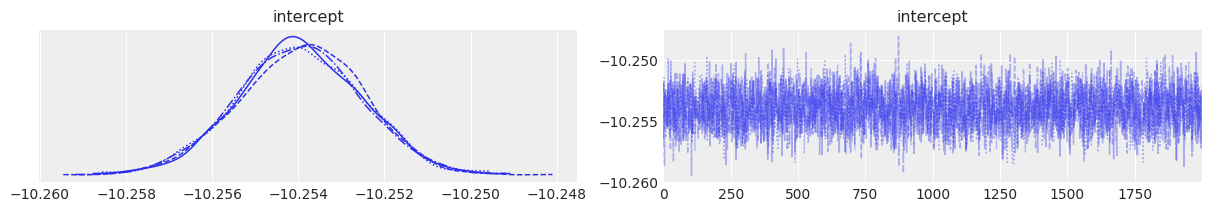

In [7]:
az.plot_trace(idata)
az.summary(idata, group='posterior')

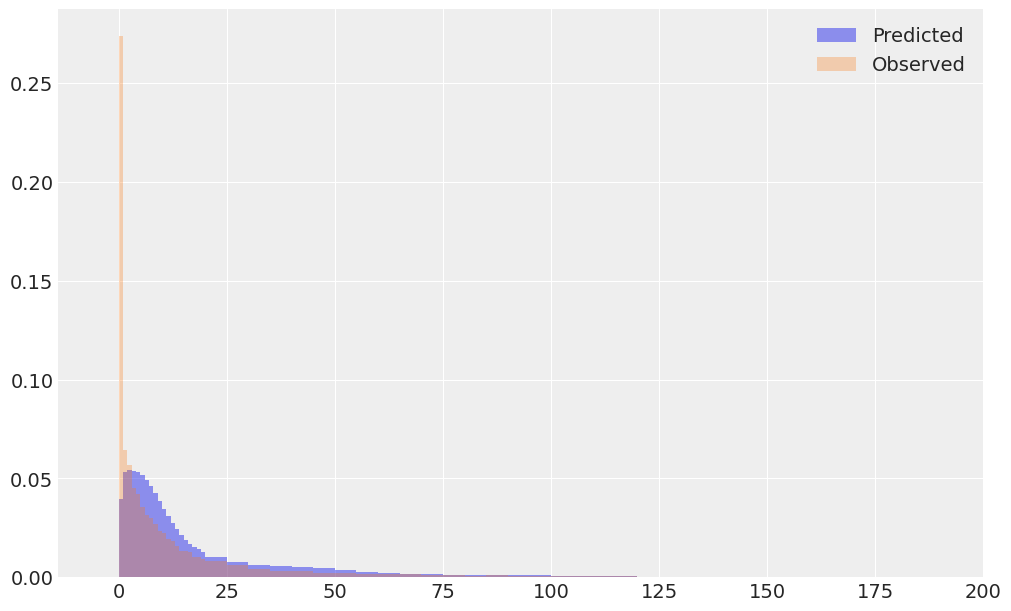

In [8]:
hist_plot(idata)

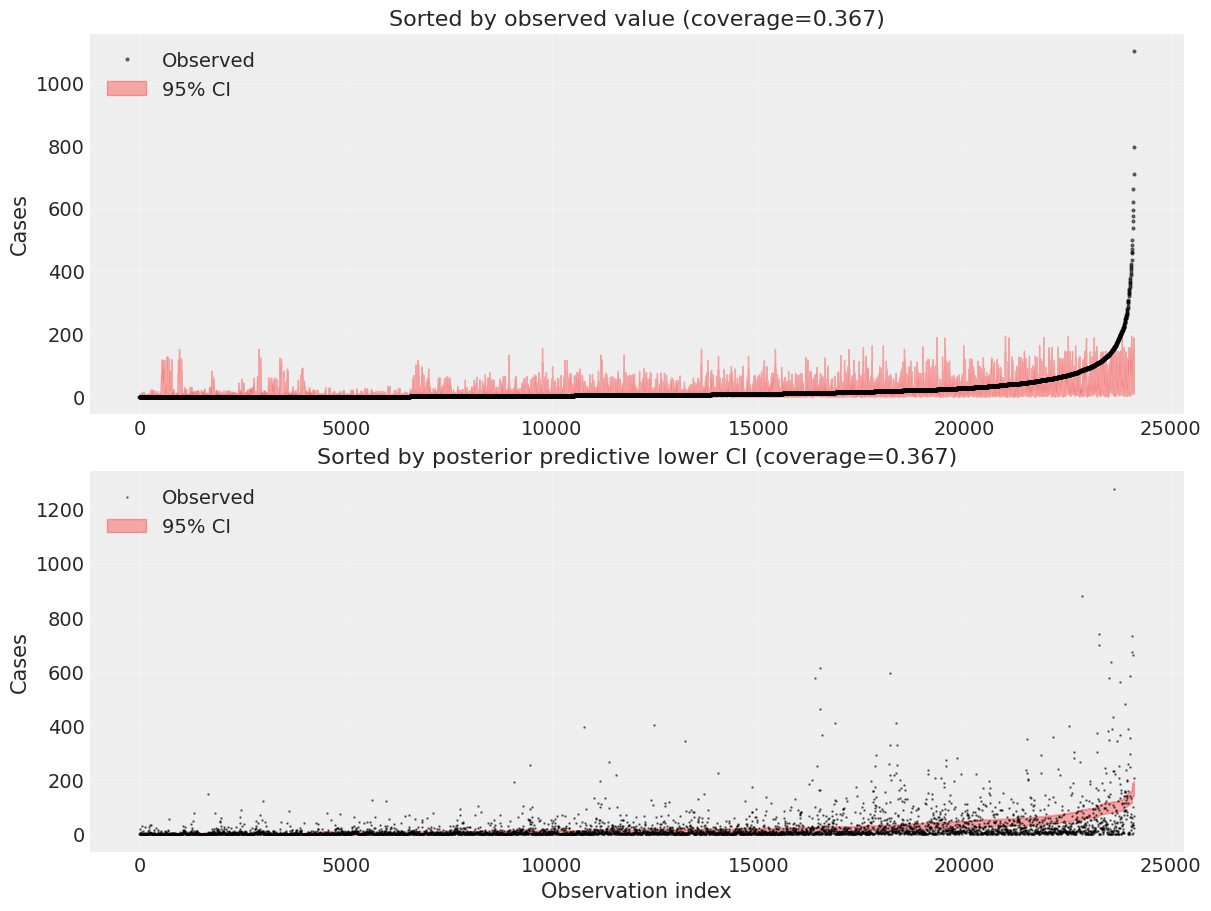

In [9]:
CI_plot_both(idata)

In [10]:
# az.waic(idata)

In [11]:
loo = az.loo(idata)
loo

Computed from 8000 posterior samples and 24107 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -469903.07  9995.75
p_loo      105.44        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     24107  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

In [12]:
# az.plot_khat(loo)

There are some highly influential samples so that the posterior excluding them is very different to the posterior including them (diagnosed through khat values of Importance Sampling weights).

Seems zero inflated, model doesn't predict this many zeros.

0.3669058779607583


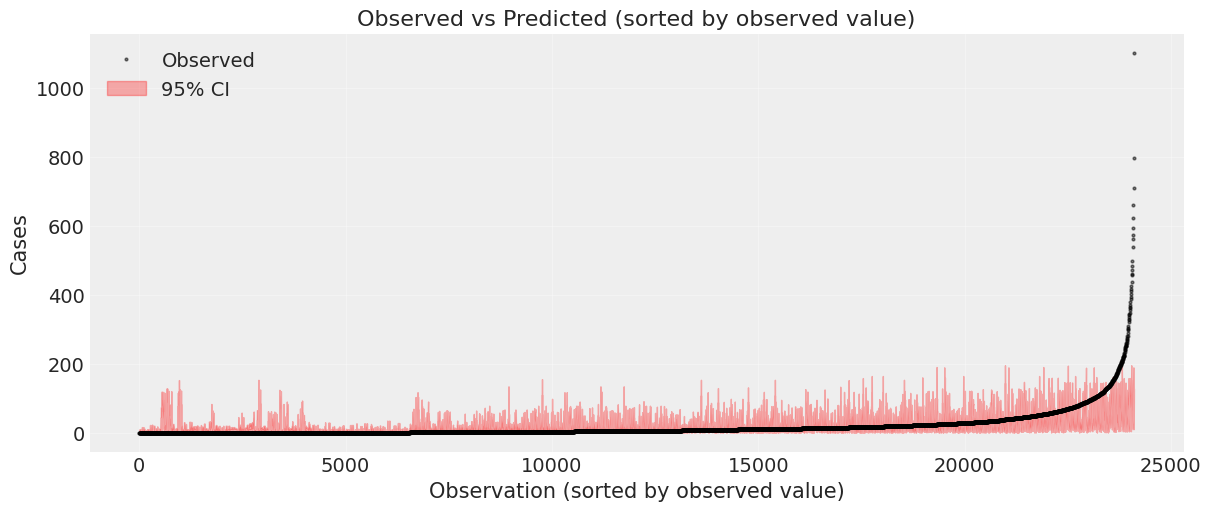

In [13]:
CI_plot(idata)

0.3669058779607583


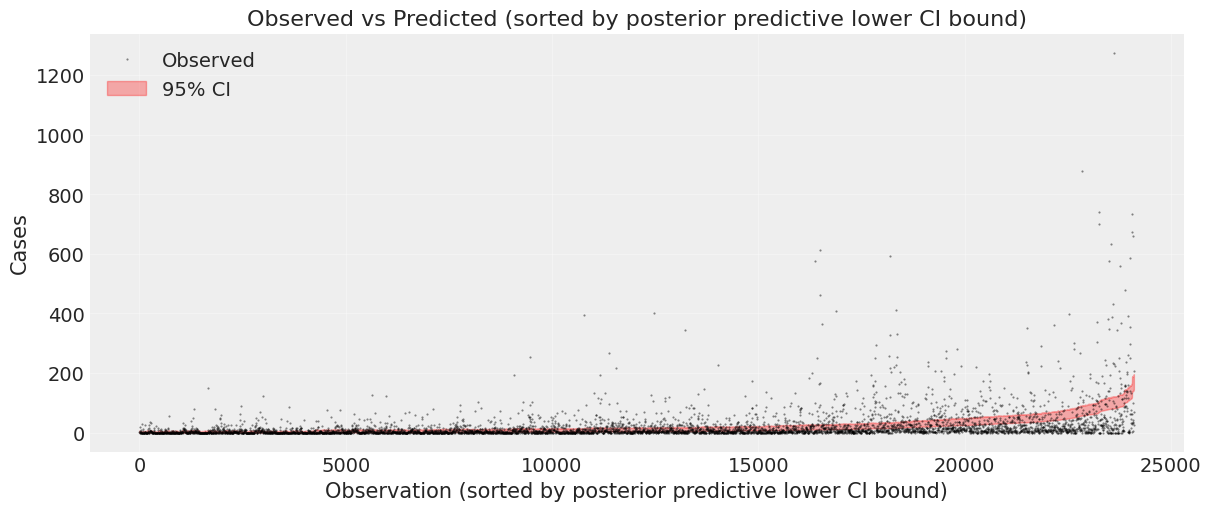

In [14]:
CI_plot_alt(idata)

Extreme values are not captured. Hopefully additional data gives more insight so that posterior CI's cover observed values better.

---
# Intercept only model (NB)

In [20]:
model_intercept_nb = pm.Model()
with model_intercept_nb:
    # Priors
    alpha = pm.Exponential("alpha", 0.5)
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)

    # Log-linear model with offset
    log_mu = intercept + pm.math.log(data['population'])

    # If i want to save mu samples and have readily available posterior samples
    # mu = pm.Deterministic("mu", pm.math.exp(log_mu))

    # NB likelihood
    y_obs = pm.NegativeBinomial('y_obs', mu=pm.math.exp(log_mu), alpha=alpha, observed=data['cases'])

In [21]:
with model_intercept_nb:
    idata = pm.sample(tune=1000, draws=2000, chains=4, discard_tuned_samples=True, idata_kwargs={'log_likelihood': True}, nuts_sampler="pymc")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, intercept]
/Users/lucaratzinger/.pyenv/versions/3.14.0/lib/python3.14/multiprocessing/popen_fork.py:70: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/lucaratzinger/.pyenv/versions/3.14.0/lib/python3.14/multiprocessing/popen_fork.py:70: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


In [23]:
with model_intercept_nb:
    idata = pm.sample(tune=1000, draws=2000, chains=4, discard_tuned_samples=True, nuts_sampler="nutpie")
    pm.compute_log_likelihood(idata)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,3000,0,1.16,3
,3000,0,1.06,3
,3000,0,1.11,1
,3000,0,1.21,3


Output()

In [25]:
with model_intercept_nb:
    # Generate posterior predictive samples
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42)

Sampling: [y_obs]


Output()

In [24]:
az.summary(idata, group='posterior')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_log__,-0.954,0.010,-0.975,-0.937,0.0,0.0,8046.0,6110.0,1.0
intercept,-9.955,0.011,-9.975,-9.934,0.0,0.0,8348.0,5931.0,1.0
alpha,0.385,0.004,0.377,0.392,0.0,0.0,8046.0,6110.0,1.0


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

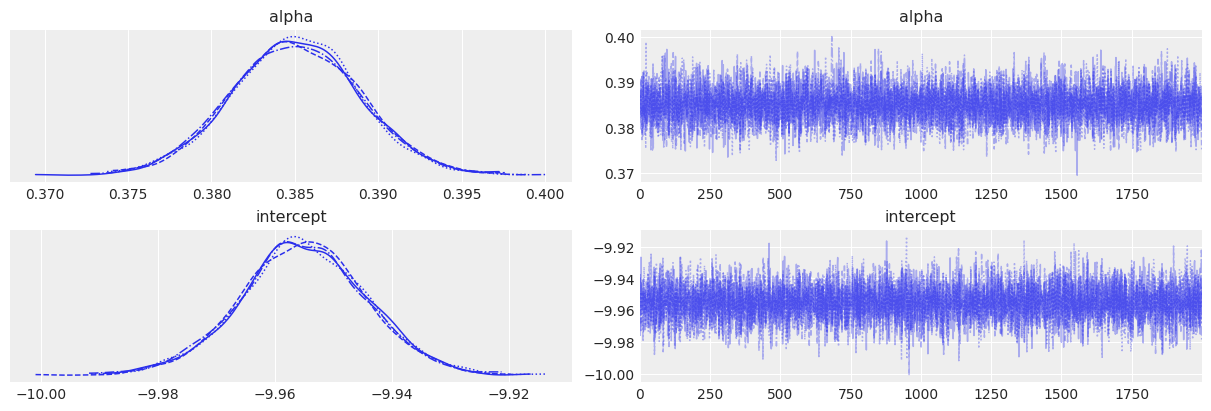

In [27]:
az.plot_trace(idata, var_names=['alpha', 'intercept'])

In [28]:
hist_plot(idata)

NameError: name 'hist_plot' is not defined

Much better histogram fit.

In [106]:
loo = az.loo(idata)
loo

Computed from 8000 posterior samples and 24107 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -83186.10   311.83
p_loo        3.73        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     24107  100.0%
   (0.70, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

<Axes: xlabel='Data Point', ylabel='Shape parameter k'>

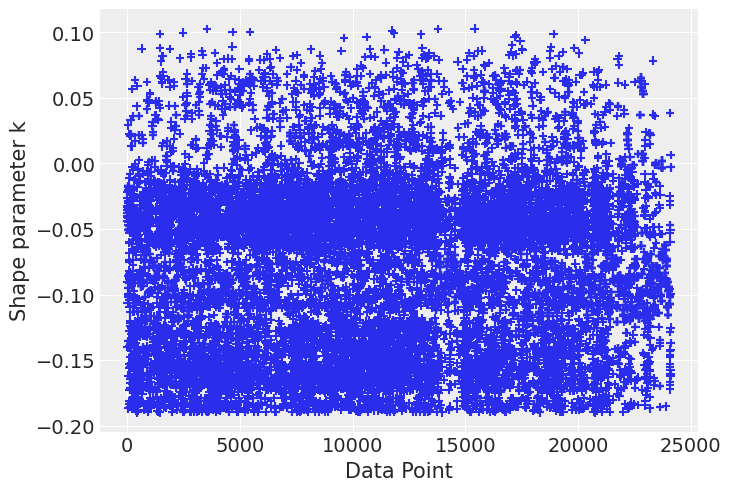

In [107]:
az.plot_khat(loo)

0.9706309370722197


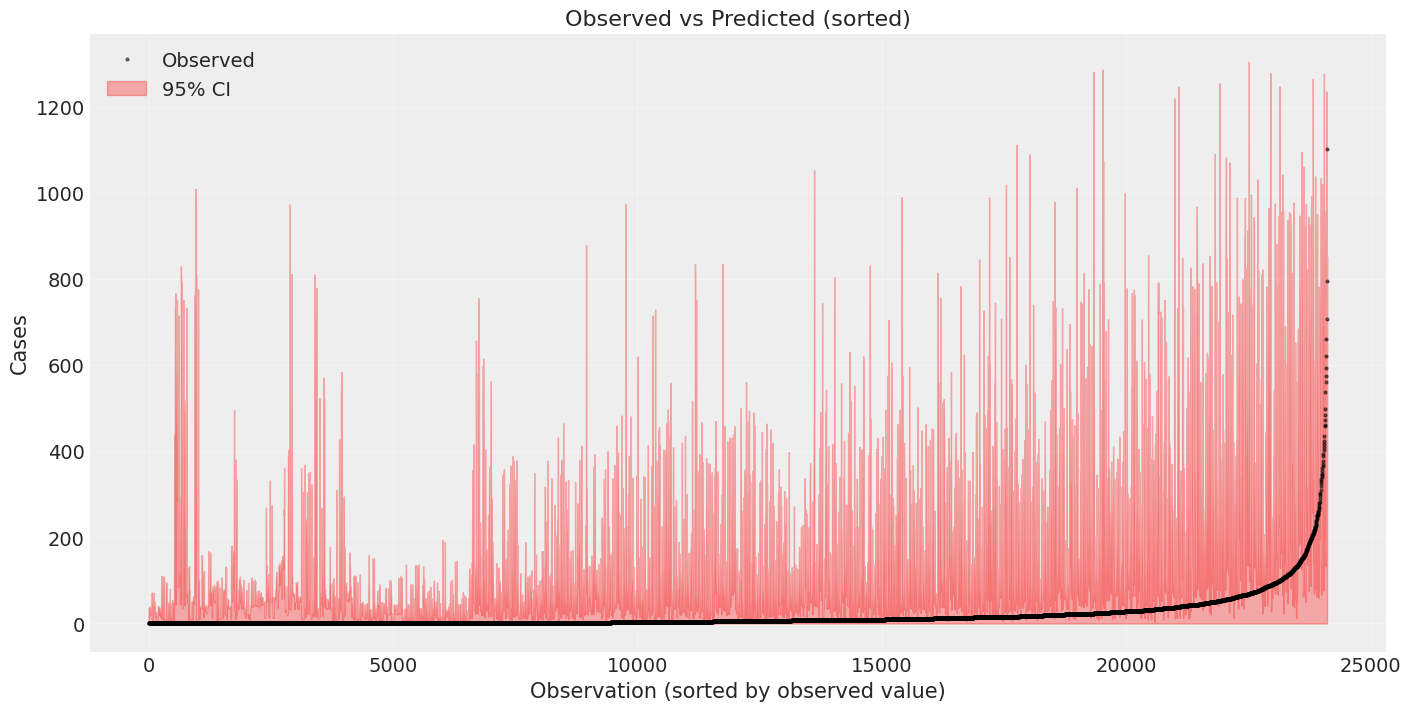

In [115]:
CI_plot(idata)

0.9706309370722197


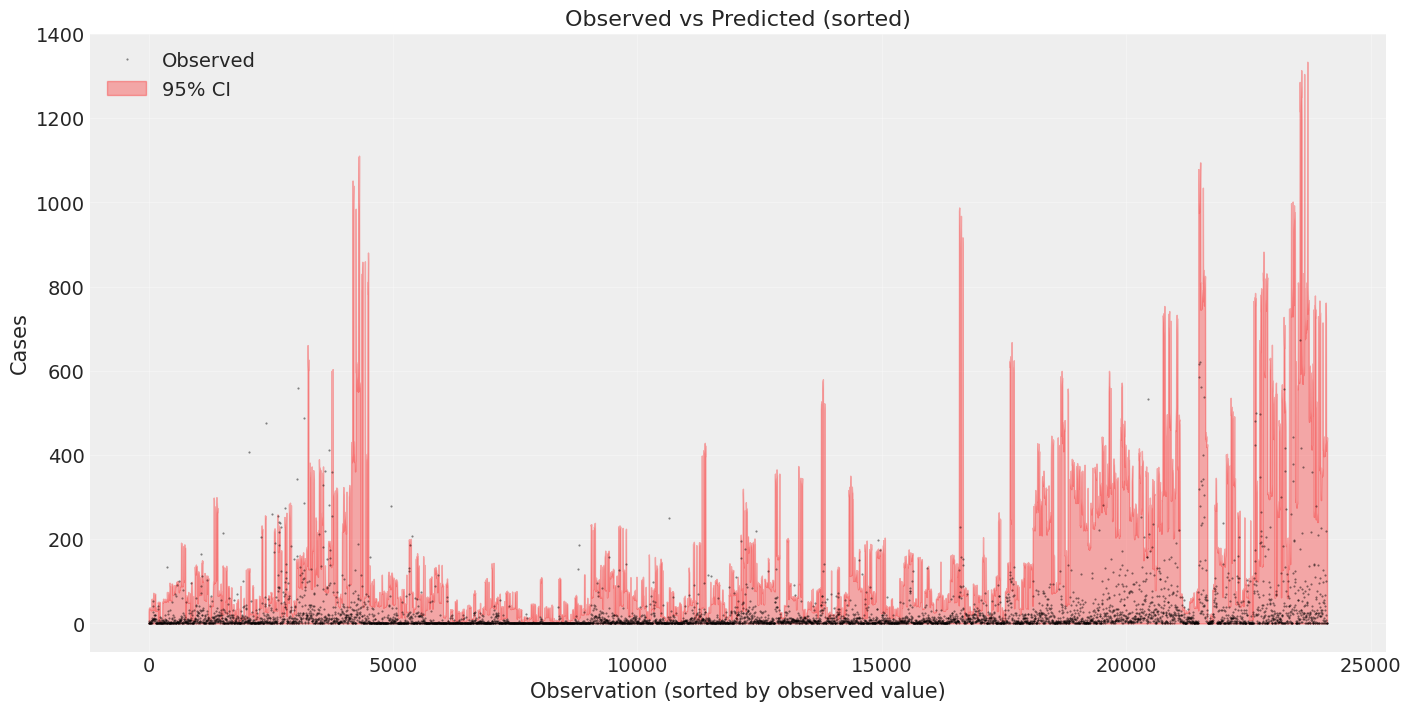

In [116]:
CI_plot_alt(idata)

---

# Intercept + Surveillance

In [66]:
model_intercept_surveillance = pm.Model()
with model_intercept_surveillance:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)

    # Log-linear model with offset
    log_mu = intercept + pm.math.log(data['population']) + pm.math.log(data['urban_surveillance_pop_weighted']+1e-3)

    # If i want to save mu samples and have readily available posterior samples
    # mu = pm.Deterministic("mu", pm.math.exp(log_mu))

    # Poisson likelihood
    y_obs = pm.Poisson('y_obs', mu=pm.math.exp(log_mu), observed=data['cases'])

In [67]:
with model_intercept_surveillance:
    idata = pm.sample(tune=1000, draws=2000, chains=4, discard_tuned_samples=True, idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [68]:
with model_intercept_surveillance:
    # Generate posterior predictive samples
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42)

Sampling: [y_obs]


Output()

In [69]:
az.summary(idata, group='posterior')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-10.153,0.002,-10.157,-10.15,0.0,0.0,3288.0,5180.0,1.0


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

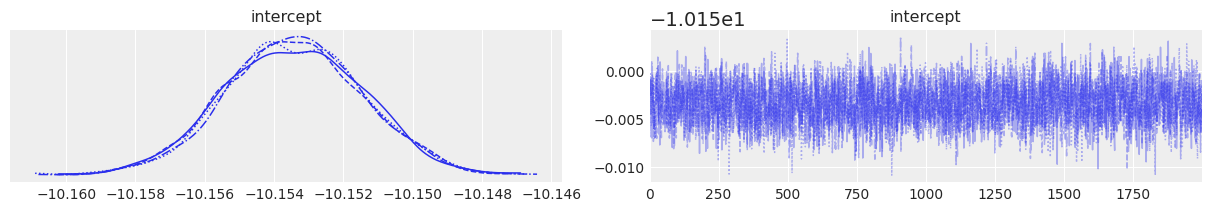

In [70]:
az.plot_trace(idata)

In [71]:
loo = az.loo(idata)
loo

/Users/lucaratzinger/.pyenv/versions/p-phylo-venv/lib/python3.14/site-packages/arviz/stats/stats.py:782: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 8000 posterior samples and 12050 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -229582.26  6477.35
p_loo      106.80        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     12048  100.0%
   (0.70, 1]   (bad)          2    0.0%
   (1, Inf)   (very bad)     0    0.0%

<Axes: xlabel='Data Point', ylabel='Shape parameter k'>

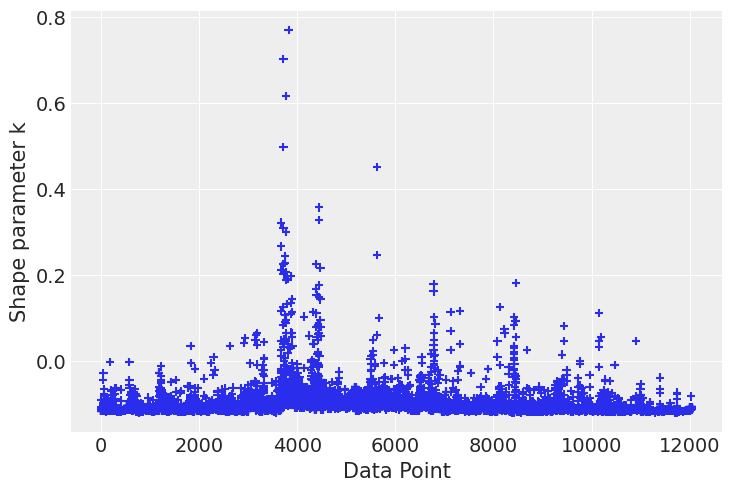

In [72]:
az.plot_khat(loo)

<Axes: xlabel='y_obs'>

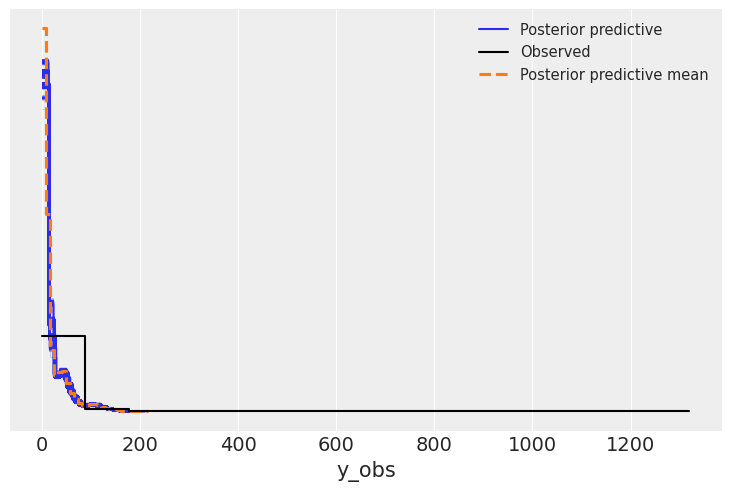

In [73]:
az.plot_ppc(idata)

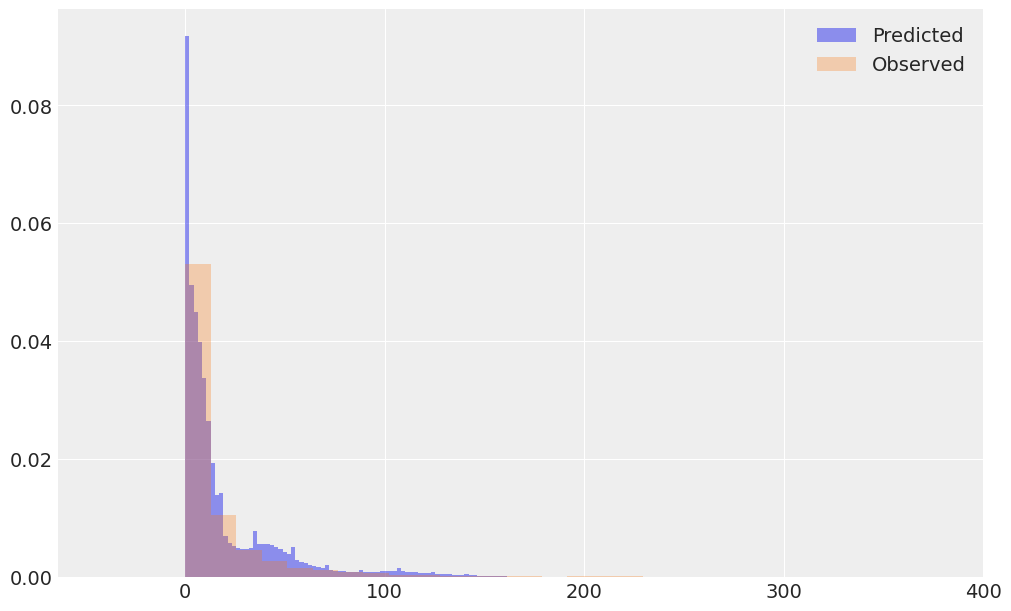

In [74]:
hist_plot(idata)

/var/folders/b8/9304zr7954v8gzzw42t51n4r0000gq/T/ipykernel_1008/728850683.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


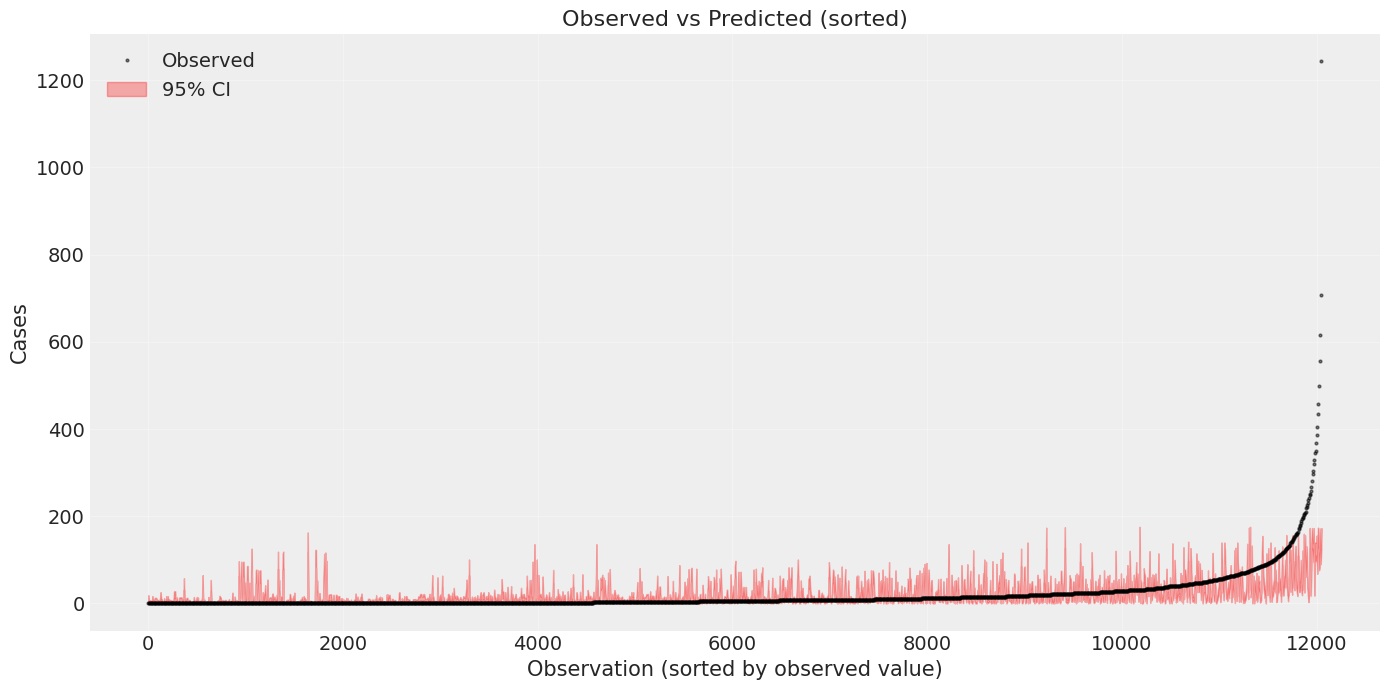

In [75]:
CI_plot(idata)

---

# Intercept + Surveillance + Urbanisation

In [76]:
model_isu = pm.Model()
with model_isu:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)
    beta_u = pm.Normal("beta_u", mu=0, sigma=1)

    # Log-linear model with offset
    log_mu = intercept + pm.math.log(data['population']) + pm.math.log(data['surveillance_pop_weighted']) + beta_u*data['urbanisation_pop_weighted']

    # If i want to save mu samples and have readily available posterior samples
    # mu = pm.Deterministic("mu", pm.math.exp(log_mu))

    # Poisson likelihood
    y_obs = pm.Poisson('y_obs', mu=pm.math.exp(log_mu), observed=data['cases'])

In [77]:
with model_isu:
    idata = pm.sample(tune=1000, draws=2000, chains=4, discard_tuned_samples=True, idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_u]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


In [78]:
with model_isu:
    # Generate posterior predictive samples
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42)

Sampling: [y_obs]


Output()

In [79]:
az.summary(idata, group='posterior')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-10.042,0.007,-10.055,-10.03,0.0,0.0,1570.0,1426.0,1.0
beta_u,-0.076,0.008,-0.091,-0.06,0.0,0.0,1569.0,1589.0,1.0


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'beta_u'}>,
        <Axes: title={'center': 'beta_u'}>]], dtype=object)

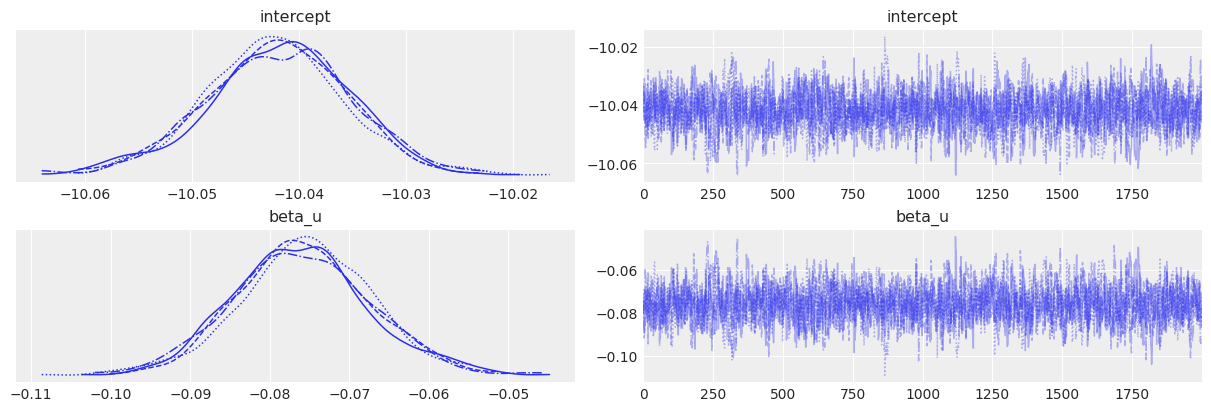

In [80]:
az.plot_trace(idata)

In [81]:
loo = az.loo(idata)
loo

/Users/lucaratzinger/.pyenv/versions/p-phylo-venv/lib/python3.14/site-packages/arviz/stats/stats.py:782: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 8000 posterior samples and 12050 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -232176.97  6487.47
p_loo      223.30        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     12046  100.0%
   (0.70, 1]   (bad)          1    0.0%
   (1, Inf)   (very bad)     3    0.0%

<Axes: xlabel='Data Point', ylabel='Shape parameter k'>

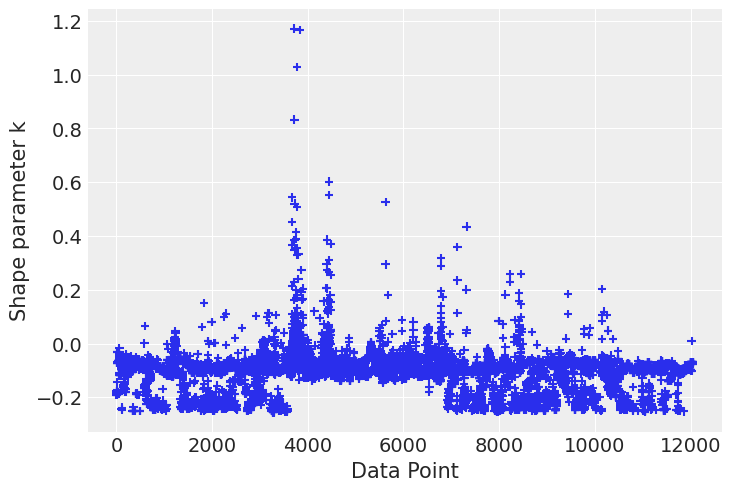

In [82]:
az.plot_khat(loo)

<Axes: xlabel='y_obs'>

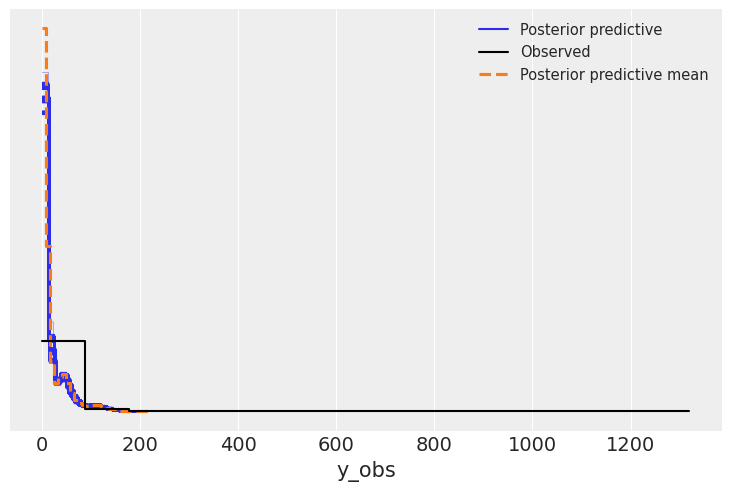

In [83]:
az.plot_ppc(idata)

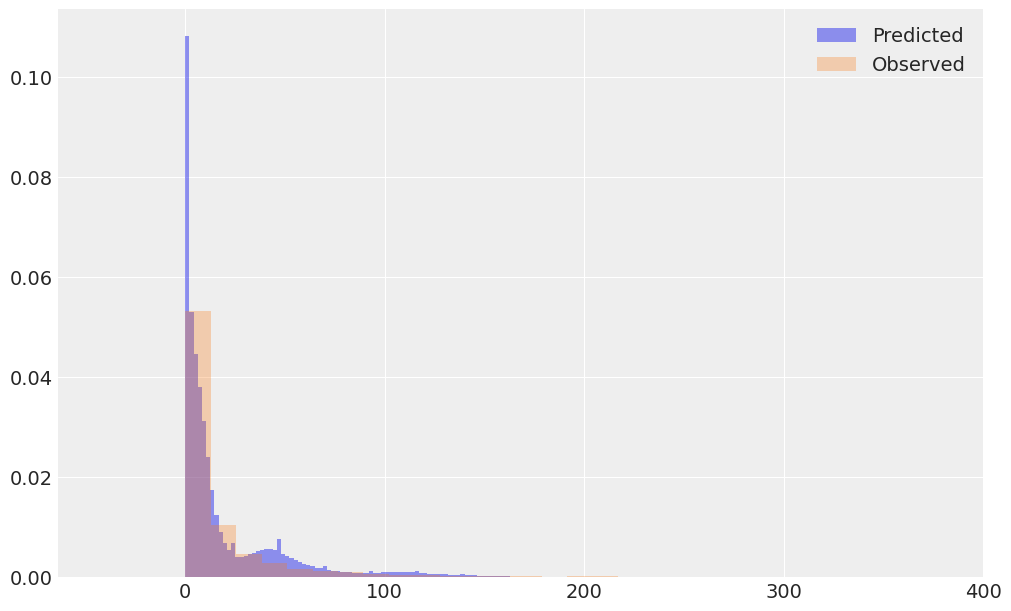

In [84]:
hist_plot(idata)

/var/folders/b8/9304zr7954v8gzzw42t51n4r0000gq/T/ipykernel_1008/728850683.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


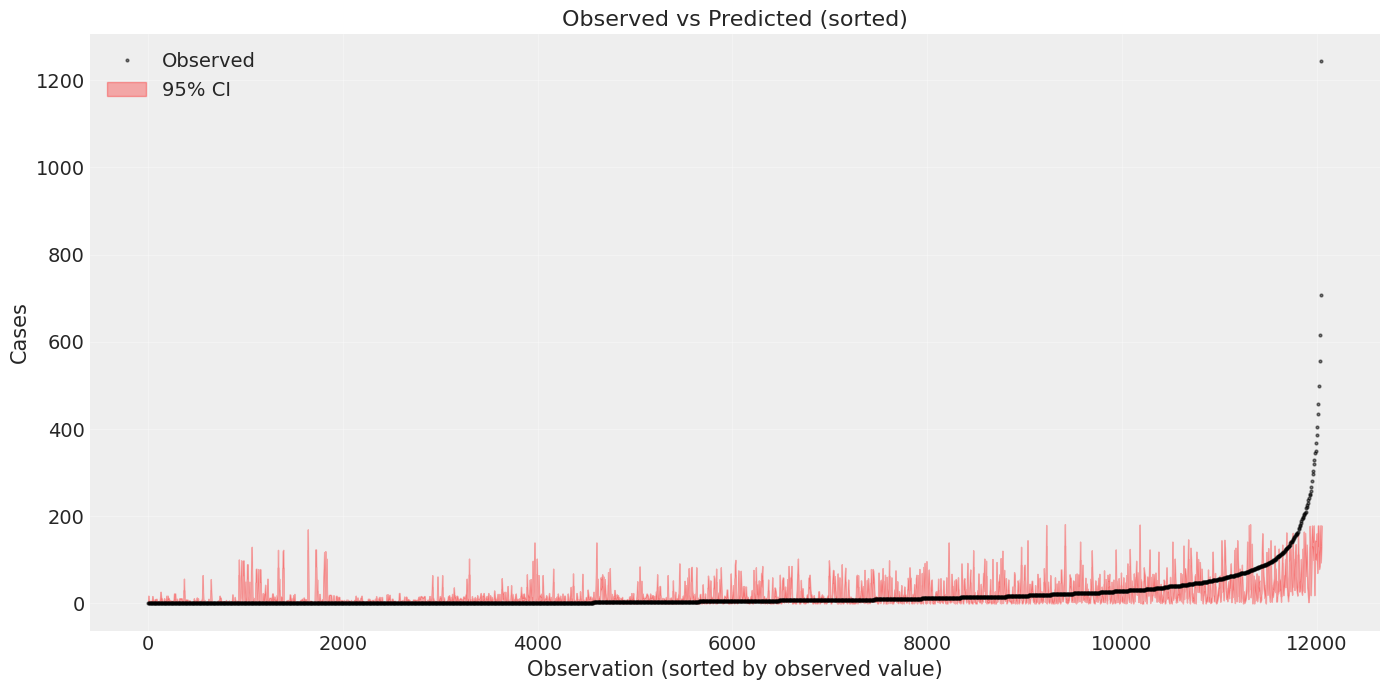

In [85]:
CI_plot(idata)

---
# ISU + 1 spline (mean temp lag 0)

In [19]:
model_isu_spline = pm.Model()
with model_isu_spline:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=2.5)
    beta_u = pm.Normal("beta_u", mu=0, sigma=1)

    # spline
    # degree=3 gives cubic splines
    num_knots = 3
    knot_list = np.percentile(data['t2m_mean_pop_weighted (0)'], np.linspace(0, 100, num_knots + 2))[1:-1]
    B = dmatrix(
    "bs(t2m_mean, knots=knots, degree=2, include_intercept=True) - 1",
    {"t2m_mean": data['t2m_mean_pop_weighted (0)'], "knots": knot_list},)
    
    # Spline coefficients
    sigma_w = pm.HalfNormal("sigma_w", sigma=0.5)
    w = pm.Normal("w", mu=0, sigma=1, size=B.shape[1], dims="splines")
    
    # Spline contribution
    f_temp = sigma_w * pm.math.dot(np.asarray(B, order="F"), w.T)
    
    # Log-link
    log_mu = (intercept + 
              pm.math.log(data['population']) + 
              pm.math.log(data['surveillance_pop_weighted'] + 1e-3) + 
              beta_u * data['urbanisation_pop_weighted'] +
              f_temp)
    # If i want to save mu samples and have readily available posterior samples
    # mu = pm.Deterministic("mu", pm.math.exp(log_mu))

    # Poisson likelihood
    y_obs = pm.Poisson('y_obs', mu=pm.math.exp(log_mu), observed=data['cases'])

In [20]:
with model_isu_spline:
    idata = pm.sample(tune=800, draws=1500, chains=4, discard_tuned_samples=True, idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_u, sigma_w, w]


Output()

Sampling 4 chains for 800 tune and 1_500 draw iterations (3_200 + 6_000 draws total) took 250 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [21]:
az.summary(idata, group='posterior')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-10.446,0.672,-11.638,-9.131,0.024,0.014,775.0,1378.0,1.0
beta_u,-0.032,0.009,-0.049,-0.016,0.000,0.000,3219.0,2599.0,1.0
w[0],-0.918,0.422,-1.656,-0.099,0.014,0.008,893.0,1418.0,1.0
w[1],0.760,0.472,-0.148,1.607,0.017,0.010,776.0,1202.0,1.0
w[2],0.139,0.434,-0.703,0.910,0.016,0.009,778.0,1208.0,1.0
w[3],0.348,0.445,-0.486,1.168,0.016,0.010,776.0,1177.0,1.0
w[4],0.457,0.451,-0.381,1.298,0.016,0.010,776.0,1171.0,1.0
w[5],-3.434,0.575,-4.509,-2.361,0.014,0.010,1709.0,2177.0,1.0
sigma_w,1.556,0.234,1.129,1.995,0.005,0.004,1941.0,2267.0,1.0


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'beta_u'}>,
        <Axes: title={'center': 'beta_u'}>],
       [<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>],
       [<Axes: title={'center': 'sigma_w'}>,
        <Axes: title={'center': 'sigma_w'}>]], dtype=object)

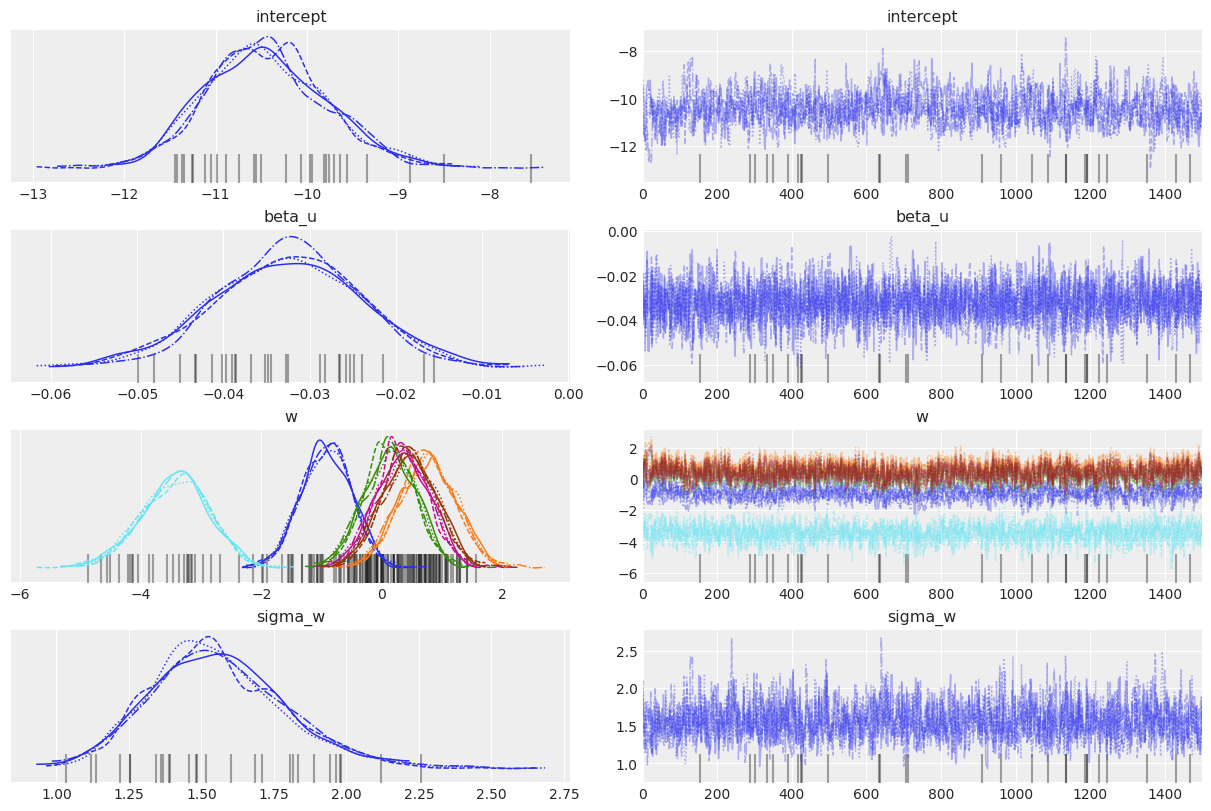

In [22]:
az.plot_trace(idata)

In [23]:
with model_isu_spline:
    # Generate posterior predictive samples
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42)

Sampling: [y_obs]


Output()

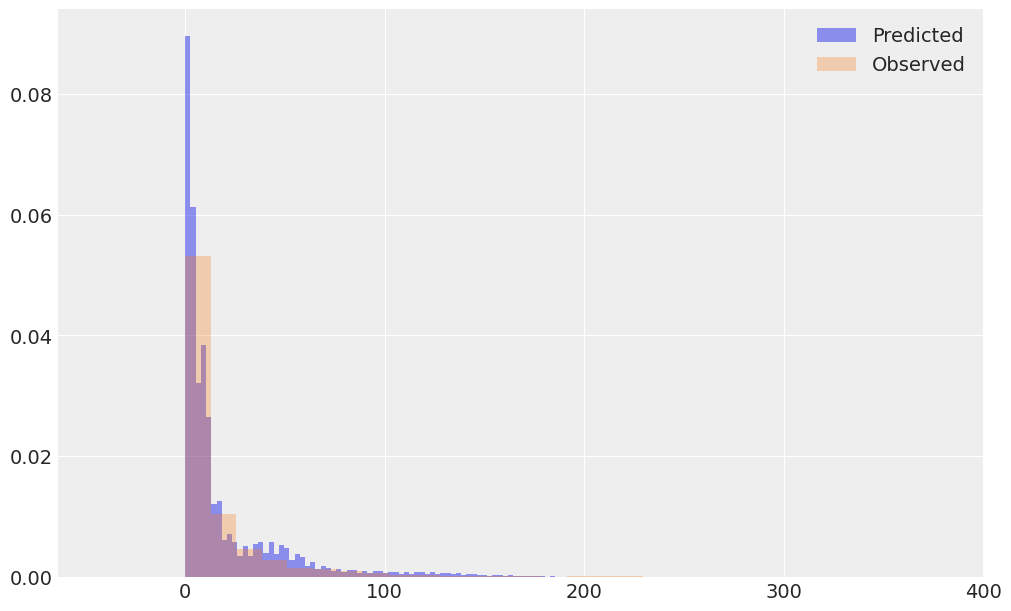

In [24]:
hist_plot(idata)

/var/folders/b8/9304zr7954v8gzzw42t51n4r0000gq/T/ipykernel_4307/827650694.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


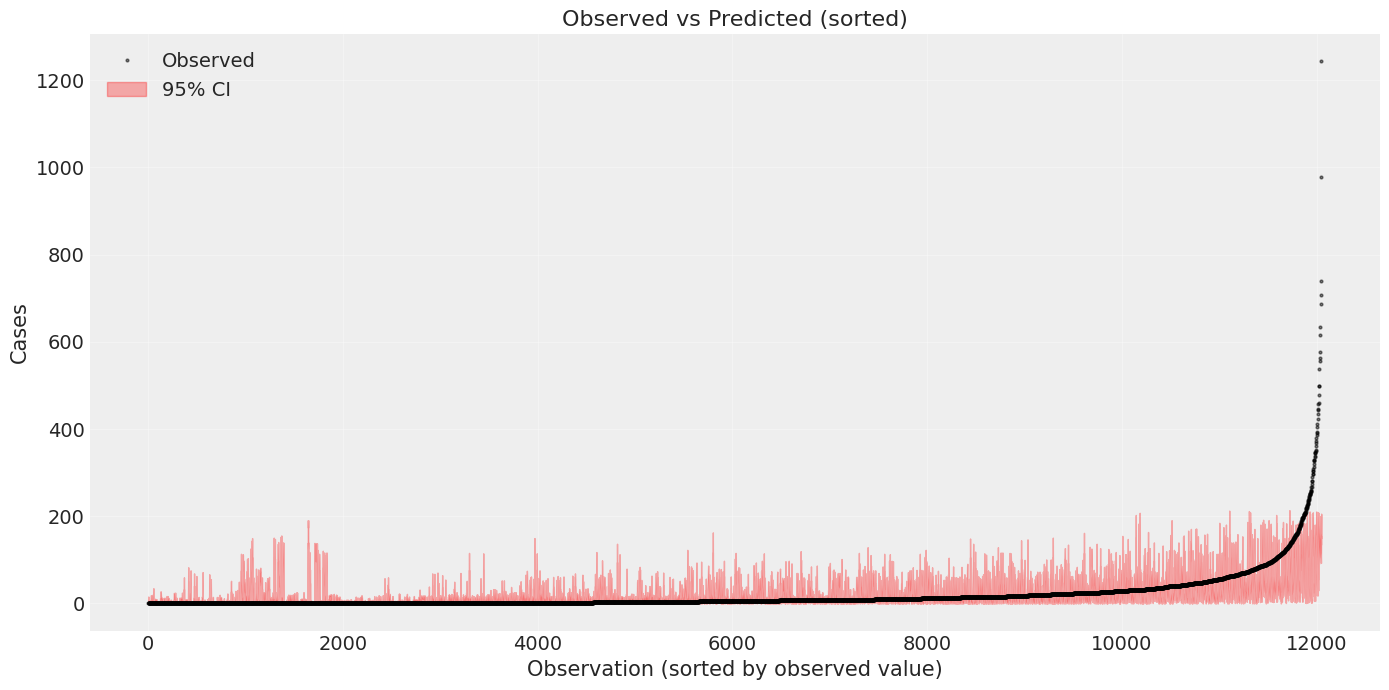

In [25]:
CI_plot(idata)

array([[<Axes: title={'center': 'w\n0'}>,
        <Axes: title={'center': 'w\n1'}>,
        <Axes: title={'center': 'w\n2'}>],
       [<Axes: title={'center': 'w\n3'}>,
        <Axes: title={'center': 'w\n4'}>,
        <Axes: title={'center': 'w\n5'}>],
       [<Axes: title={'center': 'sigma_w'}>, <Axes: >, <Axes: >]],
      dtype=object)

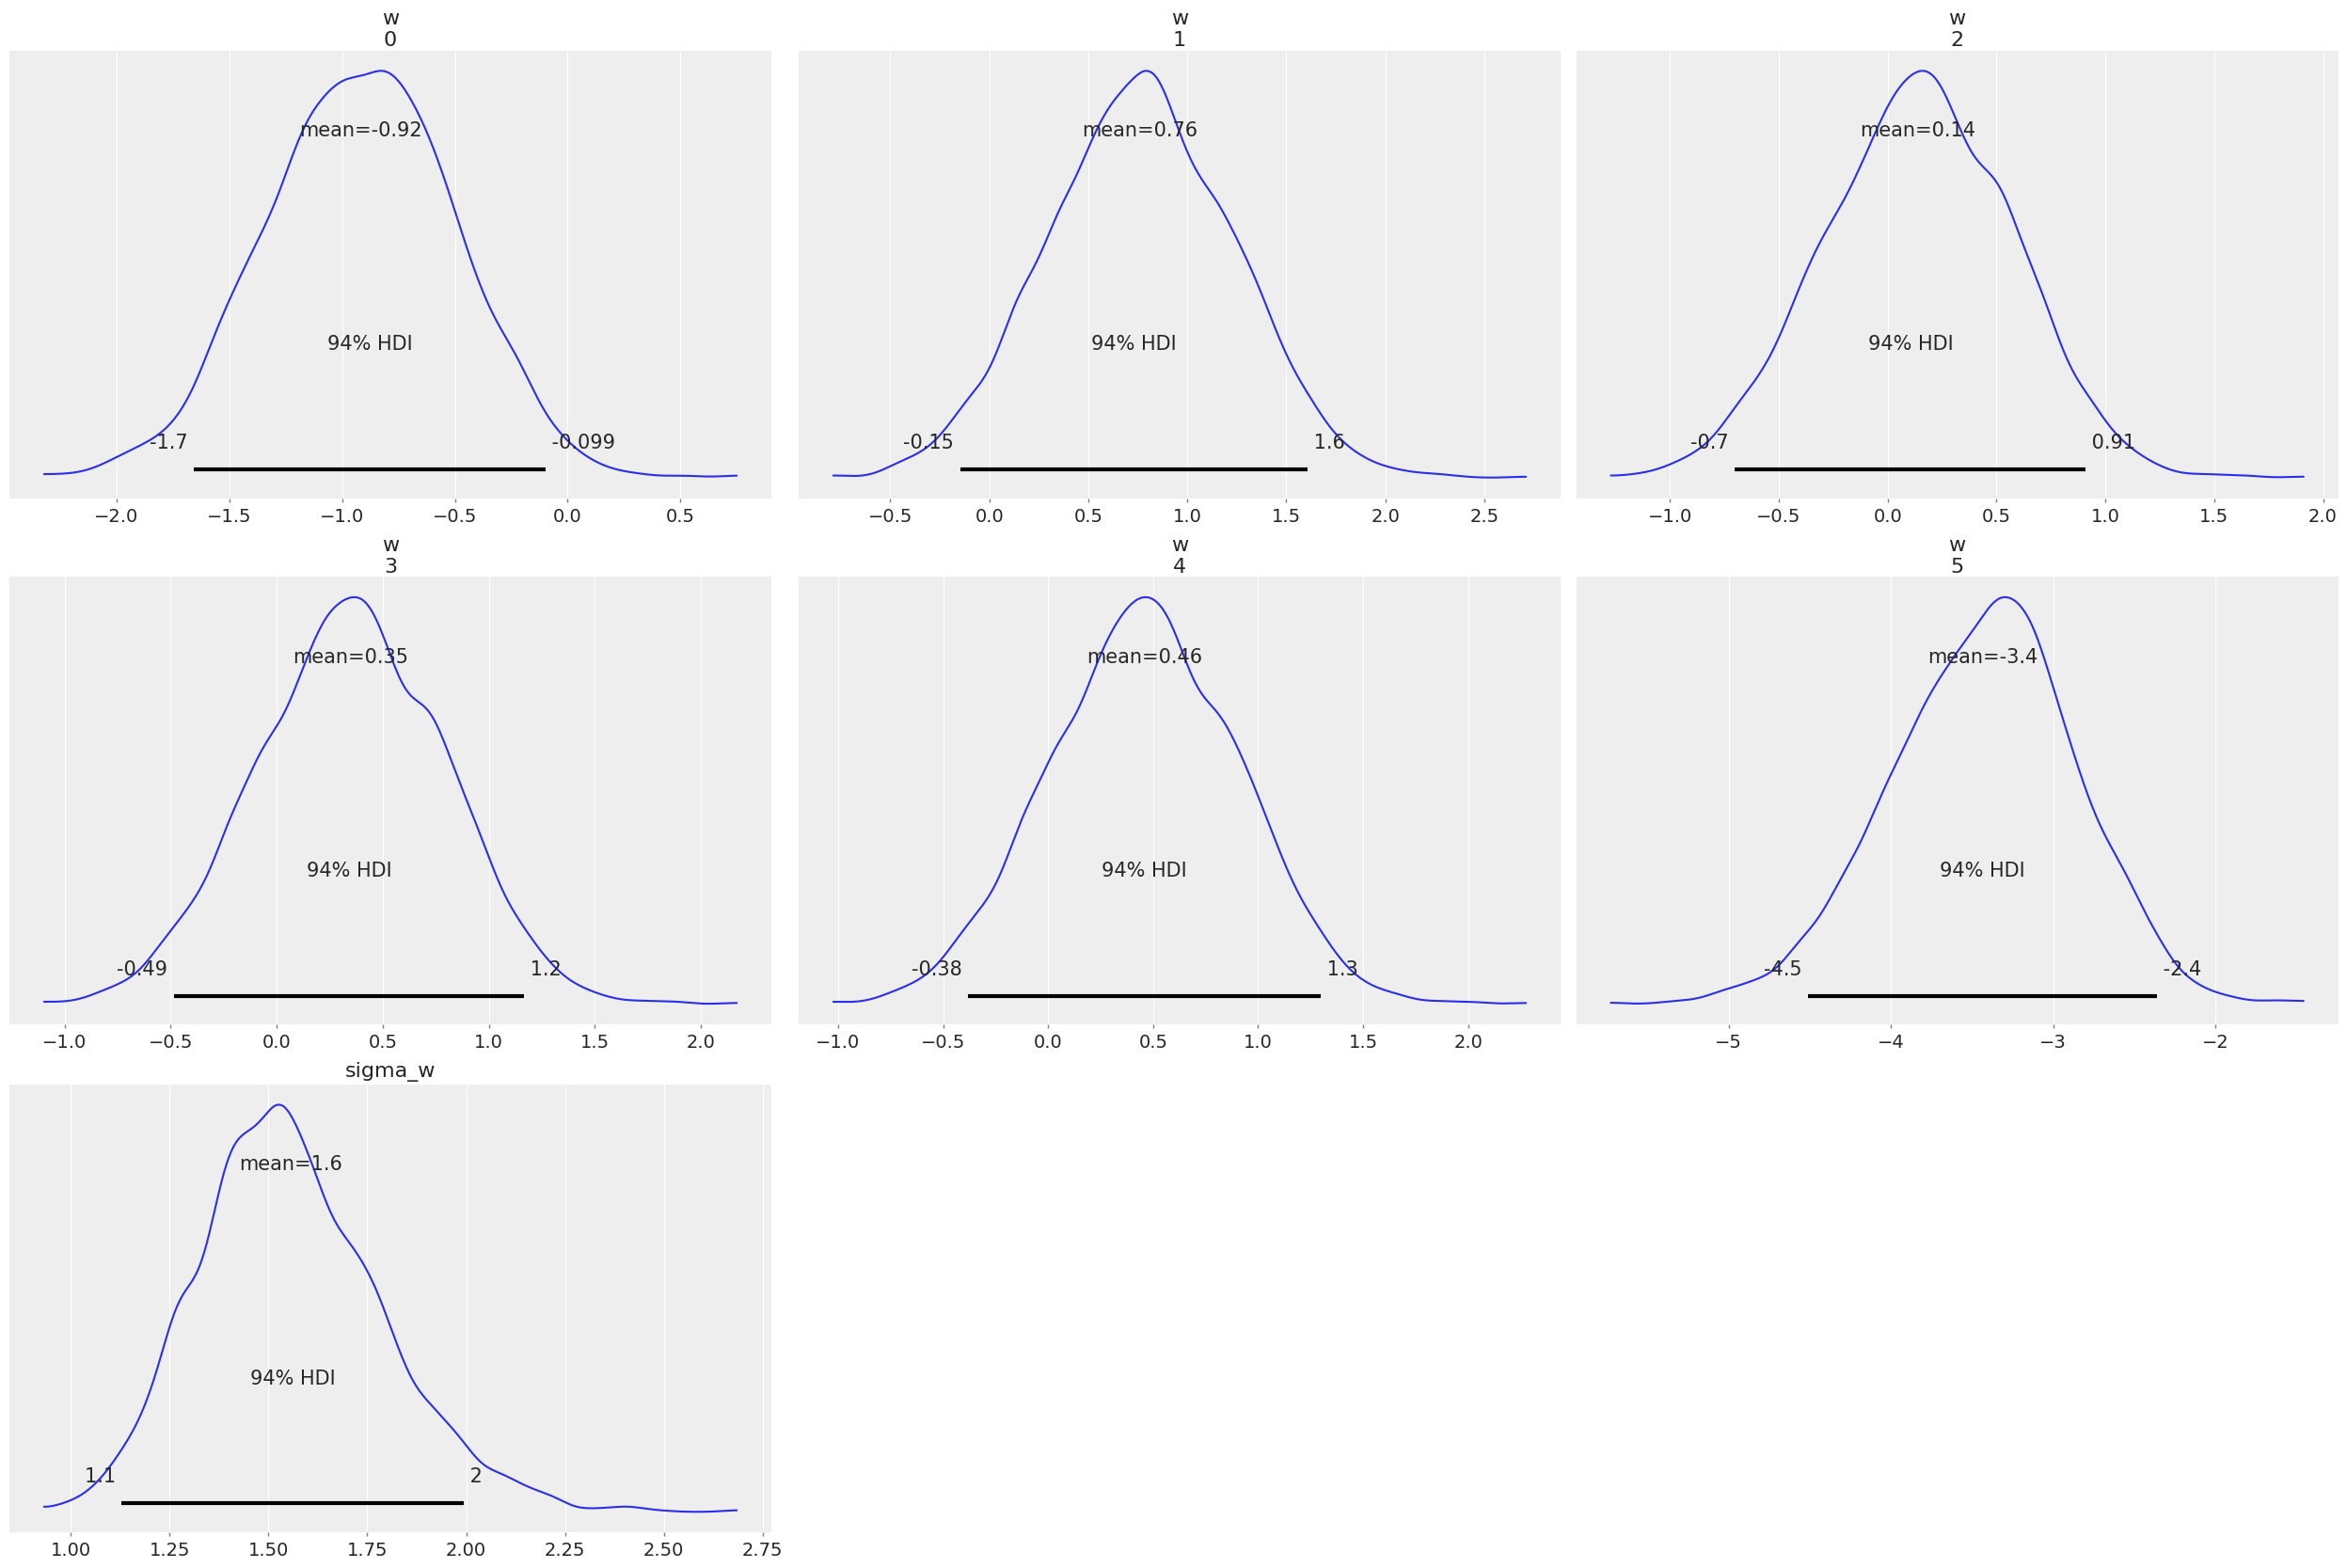

In [26]:
az.plot_posterior(idata, var_names=["w", "sigma_w"])

In [ ]:
num_knots1 = 3
knot_list1 = np.percentile(data['t2m_mean_pop_weighted (0)'], np.linspace(0, 100, num_knots1 + 2))[1:-1]
B1 = dmatrix(
"bs(s1, knots=knots, degree=3, include_intercept=False)",
{"s1": data['t2m_mean_pop_weighted (0)'], "knots": knot_list1},)

In [34]:
B1 = np.asarray(B1)

In [43]:
w = np.zeros(B1.shape[1])

In [38]:
f = np.dot(np.asarray(B1, order="F"), w.T)

In [39]:
np.asarray(f)

array([0., 0., 0., ..., 0., 0., 0.], shape=(24107,))

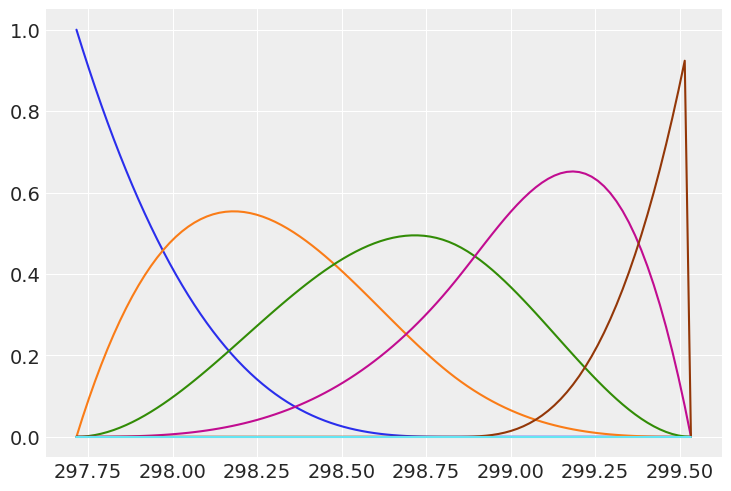

In [94]:
w = np.zeros(B.shape[1])
for i in range(len(w)):
    w1 = w.copy()
    w1[i]=1
    f = np.dot(np.asarray(B, order="F"), w1.T)
    plt.plot(x, f)

In [69]:
w1 = w.copy()
w1[2]=1

In [93]:
num_knots1 = 3
x = np.linspace(knot_list1[0], knot_list1[-1], 100)
knot_list1 = np.percentile(data['t2m_mean_pop_weighted (0)'], np.linspace(0, 100, num_knots1 + 2))[1:-1]
B = dmatrix(
"bs(s1, knots=knots, degree=3, include_intercept=False)-1",
{"s1": x, "knots": knot_list1},)

In [77]:
f = np.dot(np.asarray(B, order="F"), w1.T)

In [78]:
f

array([0.00000000e+00, 4.81416275e-02, 9.37077262e-02, 1.36751718e-01,
       1.77327024e-01, 2.15487067e-01, 2.51285268e-01, 2.84775048e-01,
       3.16009829e-01, 3.45043033e-01, 3.71928082e-01, 3.96718397e-01,
       4.19467400e-01, 4.40228512e-01, 4.59055155e-01, 4.76000751e-01,
       4.91118721e-01, 5.04462488e-01, 5.16085472e-01, 5.26041095e-01,
       5.34382779e-01, 5.41163946e-01, 5.46438017e-01, 5.50258414e-01,
       5.52678558e-01, 5.53751872e-01, 5.53531776e-01, 5.52071693e-01,
       5.49425044e-01, 5.45645251e-01, 5.40785735e-01, 5.34899919e-01,
       5.28041223e-01, 5.20263069e-01, 5.11618879e-01, 5.02162075e-01,
       4.91946078e-01, 4.81024310e-01, 4.69450193e-01, 4.57277148e-01,
       4.44558597e-01, 4.31347961e-01, 4.17698662e-01, 4.03664123e-01,
       3.89297763e-01, 3.74653006e-01, 3.59783272e-01, 3.44741984e-01,
       3.29582563e-01, 3.14358430e-01, 2.99123008e-01, 2.83929718e-01,
       2.68831981e-01, 2.53883220e-01, 2.39136855e-01, 2.24646309e-01,
      

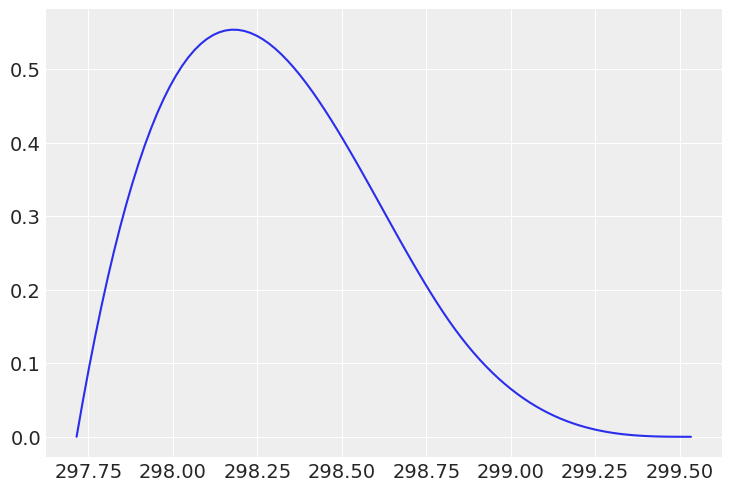

In [79]:
plt.plot(x, f)